## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        trace_df=trace_df.drop(['wifi_val1'], axis=1)
        trace_df=trace_df.drop(['wifi_val2'], axis=1)
        trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,5))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
waypoint_sequence[0]

[198.39352660531696,
 163.5148854601227,
 198.41872321063394,
 198.36833,
 163.52063,
 163.50914092024541]

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 44943
Number of targets 44943
Number of timeslots in first sequence 5
Number of timeslots in tenth sequence 5
Number of timeslots in hundredth sequence 5


# Part 2 

### After knowing the floor, now we need to predict waypoints on that floor.

### We assume that floor B1 was predicted in first part. So, for this part we will only take data of floor B1.

In [ ]:
len(waypoint_sequence)

44943

In [ ]:
len(sequences)

44943

In [ ]:
##We will divide the area into grids. But first we need to know the dimensions to work with
wp_df = pd.DataFrame(waypoint_sequence, columns = ['avg_x','avg_y','max_x','min_x','max_y','min_y',])
wp_df=wp_df.head(len(sequences))  #number of sequences for floor B1
wp_df = wp_df.round(decimals=5)
floor_max_x=wp_df['max_x'].max()
floor_min_x=wp_df['min_x'].min()
floor_max_y=wp_df['max_y'].max()
floor_min_y=wp_df['min_y'].min()
print(floor_max_x,floor_min_x,floor_max_y,floor_min_y)

233.94418 36.63454 192.99721 75.00506


In [ ]:
#Creating grid for labelling
#We will create a 10X10 grid for 100 labels
array_x=np.linspace(floor_min_x,floor_max_x,11)
array_y=np.linspace(floor_min_y,floor_max_y,11)
label=list()
k=0
for j in range(1,11):
  for i in range(1,11):
    label.append([array_x[i],array_y[j],k])
    k+=1  

In [ ]:
#Now we need to give labels to our waypoints sequence on the basis of average waypoints
print(wp_df.head())
for i in range(len(wp_df)):
  for j in range(len(label)):
    if(wp_df.at[i,'avg_x']<=label[j][0]):
       for p in range(len(label)):
         if(wp_df.at[i,'avg_y']<=label[p][1]):
           wp_df.at[i,'label']=label[j+p][2]
           break
       break    
print(wp_df.head(20))           

       avg_x      avg_y      max_x      min_x      max_y      min_y
0  198.39353  163.51489  198.41872  198.36833  163.52063  163.50914
1  198.45652  163.50052  198.48171  198.43132  163.50627  163.49478
2  198.51951  163.48616  198.54471  198.49431  163.49191  163.48042
3  198.58250  163.47180  198.60770  198.55730  163.47755  163.46606
4  198.64549  163.45744  198.67069  198.62030  163.46318  163.45170
        avg_x      avg_y      max_x      min_x      max_y      min_y  label
0   198.39353  163.51489  198.41872  198.36833  163.52063  163.50914   78.0
1   198.45652  163.50052  198.48171  198.43132  163.50627  163.49478   78.0
2   198.51951  163.48616  198.54471  198.49431  163.49191  163.48042   78.0
3   198.58250  163.47180  198.60770  198.55730  163.47755  163.46606   78.0
4   198.64549  163.45744  198.67069  198.62030  163.46318  163.45170   78.0
5   198.70848  163.44308  198.73368  198.68329  163.44882  163.43733   78.0
6   198.77148  163.42872  198.79667  198.74628  163.43446  1

In [ ]:
#Now we need to create new train, validation and test split for only building 1
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)

flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

44943

In [ ]:
#Creating target sequence
target_sequence2=wp_df['label'].values
#Slice the sequence to get only floor B1 data
sequences2=sequences[0:len(sequences)]
target_sequence2=np.array(target_sequence2)
target_sequence2

array([78., 78., 78., ..., 73., 73., 73.])

In [ ]:
train = [sequences2[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences2[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences2[i] for i in range(len(flags)) if flags[i]==2]
test_seq_wp=[waypoint_full_sequence[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence2[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target=to_categorical(train_target,num_classes = 100)

validation_target = np.array(validation_target)
validation_target=to_categorical(validation_target,num_classes = 100)
test_target = np.array(test_target)
test_target=to_categorical(test_target,num_classes = 100)

In [ ]:
print(sequences2[0].shape)
train_target[0]
len(test_seq_wp)

(5, 24)


6742

In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)

In [ ]:
#Trial with 100 grid cells 
from keras.layers import Dropout
seq_len = 5
seq_bredth=24
model = Sequential()
model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(seq_len, seq_bredth),merge_mode='concat'))
model.add(LSTM(256, input_shape=(3, 512)))
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 512)            575488    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
Total params: 1,408,740
Trainable params: 1,408,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#This is 100 cells simple LSTM
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
246/246 [==============================] - 49s 177ms/step - loss: 3.5233 - accuracy: 0.1159 - val_loss: 2.4341 - val_accuracy: 0.2608

Epoch 00001: val_accuracy improved from -inf to 0.26079, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 2/200
246/246 [==============================] - 41s 168ms/step - loss: 2.1269 - accuracy: 0.3241 - val_loss: 1.6560 - val_accuracy: 0.4314

Epoch 00002: val_accuracy improved from 0.26079 to 0.43139, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 3/200
246/246 [==============================] - 42s 169ms/step - loss: 1.6012 - accuracy: 0.4476 - val_loss: 1.3982 - val_accuracy: 0.5010

Epoch 00003: val_accuracy improved from 0.43139 to 0.50096, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 4/200
246/246 [==============================] - 42s 170ms/step - loss: 1.3832 - accuracy: 0.5092 - val_loss: 1.3455 - val_accuracy: 0.5177

Epoch 00004: val_accuracy improved from 0.50096 to 0.51773, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 5/200
246/246 [==============================] - 42s 172ms/step - loss: 1.2466 - accuracy: 0.5540 - val_loss: 1.2150 - val_accuracy: 0.5526

Epoch 00005: val_accuracy improved from 0.51773 to 0.55259, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 6/200
246/246 [==============================] - 42s 171ms/step - loss: 1.1629 - accuracy: 0.5780 - val_loss: 1.2810 - val_accuracy: 0.5389

Epoch 00006: val_accuracy did not improve from 0.55259
Epoch 7/200
246/246 [==============================] - 41s 168ms/step - loss: 1.1245 - accuracy: 0.5905 - val_loss: 1.1072 - val_accuracy: 0.5889

Epoch 00007: val_accuracy improved from 0.55259 to 0.58893, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 8/200
246/246 [==============================] - 42s 170ms/step - loss: 1.0451 - accuracy: 0.6199 - val_loss: 1.0884 - val_accuracy: 0.6084

Epoch 00008: val_accuracy improved from 0.58893 to 0.60837, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 9/200
246/246 [==============================] - 42s 170ms/step - loss: 0.9631 - accuracy: 0.6498 - val_loss: 1.0494 - val_accuracy: 0.6170

Epoch 00009: val_accuracy improved from 0.60837 to 0.61697, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 10/200
246/246 [==============================] - 41s 168ms/step - loss: 0.9194 - accuracy: 0.6684 - val_loss: 1.0655 - val_accuracy: 0.6063

Epoch 00010: val_accuracy did not improve from 0.61697
Epoch 11/200
246/246 [==============================] - 41s 167ms/step - loss: 0.8986 - accuracy: 0.6705 - val_loss: 1.0110 - val_accuracy: 0.6244

Epoch 00011: val_accuracy improved from 0.61697 to 0.62439, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 12/200
246/246 [==============================] - 42s 169ms/step - loss: 0.8365 - accuracy: 0.6934 - val_loss: 0.9127 - val_accuracy: 0.6595

Epoch 00012: val_accuracy improved from 0.62439 to 0.65955, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 13/200
246/246 [==============================] - 42s 169ms/step - loss: 0.7869 - accuracy: 0.7111 - val_loss: 0.9517 - val_accuracy: 0.6471

Epoch 00013: val_accuracy did not improve from 0.65955
Epoch 14/200
246/246 [==============================] - 41s 168ms/step - loss: 0.7579 - accuracy: 0.7197 - val_loss: 0.9497 - val_accuracy: 0.6538

Epoch 00014: val_accuracy did not improve from 0.65955
Epoch 15/200
246/246 [==============================] - 42s 169ms/step - loss: 0.7494 - accuracy: 0.7300 - val_loss: 0.9192 - val_accuracy: 0.6704

Epoch 00015: val_accuracy improved from 0.65955 to 0.67038, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 16/200
246/246 [==============================] - 41s 167ms/step - loss: 0.6958 - accuracy: 0.7449 - val_loss: 0.9572 - val_accuracy: 0.6613

Epoch 00016: val_accuracy did not improve from 0.67038
Epoch 17/200
246/246 [==============================] - 41s 169ms/step - loss: 0.6857 - accuracy: 0.7478 - val_loss: 0.8553 - val_accuracy: 0.6950

Epoch 00017: val_accuracy improved from 0.67038 to 0.69500, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 18/200
246/246 [==============================] - 41s 168ms/step - loss: 0.6151 - accuracy: 0.7739 - val_loss: 0.9692 - val_accuracy: 0.6622

Epoch 00018: val_accuracy did not improve from 0.69500
Epoch 19/200
246/246 [==============================] - 41s 169ms/step - loss: 0.6173 - accuracy: 0.7770 - val_loss: 0.8587 - val_accuracy: 0.6943

Epoch 00019: val_accuracy did not improve from 0.69500
Epoch 20/200
246/246 [==============================] - 42s 170ms/step - loss: 0.5613 - accuracy: 0.7960 - val_loss: 0.8143 - val_accuracy: 0.7085

Epoch 00020: val_accuracy improved from 0.69500 to 0.70850, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 21/200
246/246 [==============================] - 42s 169ms/step - loss: 0.5429 - accuracy: 0.8022 - val_loss: 0.8704 - val_accuracy: 0.6900

Epoch 00021: val_accuracy did not improve from 0.70850
Epoch 22/200
246/246 [==============================] - 41s 168ms/step - loss: 0.5325 - accuracy: 0.8044 - val_loss: 0.8515 - val_accuracy: 0.7079

Epoch 00022: val_accuracy did not improve from 0.70850
Epoch 23/200
246/246 [==============================] - 41s 168ms/step - loss: 0.4935 - accuracy: 0.8153 - val_loss: 0.8898 - val_accuracy: 0.6885

Epoch 00023: val_accuracy did not improve from 0.70850
Epoch 24/200
246/246 [==============================] - 41s 168ms/step - loss: 0.5425 - accuracy: 0.8010 - val_loss: 0.8151 - val_accuracy: 0.7098

Epoch 00024: val_accuracy improved from 0.70850 to 0.70984, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 25/200
246/246 [==============================] - 42s 169ms/step - loss: 0.4753 - accuracy: 0.8256 - val_loss: 0.8607 - val_accuracy: 0.7026

Epoch 00025: val_accuracy did not improve from 0.70984
Epoch 26/200
246/246 [==============================] - 42s 169ms/step - loss: 0.4476 - accuracy: 0.8368 - val_loss: 0.7620 - val_accuracy: 0.7371

Epoch 00026: val_accuracy improved from 0.70984 to 0.73713, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 27/200
246/246 [==============================] - 41s 168ms/step - loss: 0.4129 - accuracy: 0.8504 - val_loss: 0.8773 - val_accuracy: 0.7067

Epoch 00027: val_accuracy did not improve from 0.73713
Epoch 28/200
246/246 [==============================] - 41s 168ms/step - loss: 0.4580 - accuracy: 0.8318 - val_loss: 0.7846 - val_accuracy: 0.7308

Epoch 00028: val_accuracy did not improve from 0.73713
Epoch 29/200
246/246 [==============================] - 42s 169ms/step - loss: 0.3867 - accuracy: 0.8606 - val_loss: 0.7843 - val_accuracy: 0.7310

Epoch 00029: val_accuracy did not improve from 0.73713
Epoch 30/200
246/246 [==============================] - 41s 168ms/step - loss: 0.3564 - accuracy: 0.8671 - val_loss: 1.0233 - val_accuracy: 0.6781

Epoch 00030: val_accuracy did not improve from 0.73713
Epoch 31/200
246/246 [==============================] - 41s 167ms/step - loss: 0.3822 - accuracy: 0.8613 - val_loss: 0.8483 - val_accuracy: 0.7290

Epoch 00031: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 33/200
246/246 [==============================] - 42s 169ms/step - loss: 0.3301 - accuracy: 0.8788 - val_loss: 0.9011 - val_accuracy: 0.7106

Epoch 00033: val_accuracy did not improve from 0.74143
Epoch 34/200
246/246 [==============================] - 41s 168ms/step - loss: 0.4302 - accuracy: 0.8408 - val_loss: 0.8137 - val_accuracy: 0.7367

Epoch 00034: val_accuracy did not improve from 0.74143
Epoch 35/200
246/246 [==============================] - 41s 168ms/step - loss: 0.2985 - accuracy: 0.8917 - val_loss: 0.8720 - val_accuracy: 0.7256

Epoch 00035: val_accuracy did not improve from 0.74143
Epoch 36/200
246/246 [==============================] - 41s 169ms/step - loss: 0.3756 - accuracy: 0.8628 - val_loss: 0.7849 - val_accuracy: 0.7437

Epoch 00036: val_accuracy improved from 0.74143 to 0.74366, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 37/200
246/246 [==============================] - 42s 170ms/step - loss: 0.2682 - accuracy: 0.9024 - val_loss: 0.7730 - val_accuracy: 0.7530

Epoch 00037: val_accuracy improved from 0.74366 to 0.75300, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 38/200
246/246 [==============================] - 42s 169ms/step - loss: 0.2582 - accuracy: 0.9068 - val_loss: 0.8357 - val_accuracy: 0.7370

Epoch 00038: val_accuracy did not improve from 0.75300
Epoch 39/200
246/246 [==============================] - 41s 167ms/step - loss: 0.3276 - accuracy: 0.8847 - val_loss: 0.8202 - val_accuracy: 0.7440

Epoch 00039: val_accuracy did not improve from 0.75300
Epoch 40/200
246/246 [==============================] - 41s 168ms/step - loss: 0.2668 - accuracy: 0.9038 - val_loss: 0.8629 - val_accuracy: 0.7334

Epoch 00040: val_accuracy did not improve from 0.75300
Epoch 41/200
246/246 [==============================] - 42s 169ms/step - loss: 0.2443 - accuracy: 0.9114 - val_loss: 1.0422 - val_accuracy: 0.6977

Epoch 00041: val_accuracy did not improve from 0.75300
Epoch 42/200
246/246 [==============================] - 42s 169ms/step - loss: 0.4458 - accuracy: 0.8565 - val_loss: 0.8684 - val_accuracy: 0.7386

Epoch 00042: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 44/200
246/246 [==============================] - 42s 169ms/step - loss: 0.2150 - accuracy: 0.9243 - val_loss: 0.8426 - val_accuracy: 0.7444

Epoch 00044: val_accuracy did not improve from 0.75998
Epoch 45/200
246/246 [==============================] - 42s 169ms/step - loss: 0.2117 - accuracy: 0.9258 - val_loss: 1.0130 - val_accuracy: 0.7162

Epoch 00045: val_accuracy did not improve from 0.75998
Epoch 46/200
246/246 [==============================] - 42s 171ms/step - loss: 0.3037 - accuracy: 0.8932 - val_loss: 0.8860 - val_accuracy: 0.7401

Epoch 00046: val_accuracy did not improve from 0.75998
Epoch 47/200
246/246 [==============================] - 42s 170ms/step - loss: 0.2157 - accuracy: 0.9239 - val_loss: 0.9261 - val_accuracy: 0.7334

Epoch 00047: val_accuracy did not improve from 0.75998
Epoch 48/200
246/246 [==============================] - 42s 171ms/step - loss: 0.2334 - accuracy: 0.9185 - val_loss: 0.9046 - val_accuracy: 0.7463

Epoch 00048: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 64/200
246/246 [==============================] - 41s 168ms/step - loss: 0.1272 - accuracy: 0.9549 - val_loss: 0.9640 - val_accuracy: 0.7518

Epoch 00064: val_accuracy did not improve from 0.76547
Epoch 65/200
246/246 [==============================] - 41s 167ms/step - loss: 0.1120 - accuracy: 0.9615 - val_loss: 1.0163 - val_accuracy: 0.7515

Epoch 00065: val_accuracy did not improve from 0.76547
Epoch 66/200
246/246 [==============================] - 41s 167ms/step - loss: 0.1705 - accuracy: 0.9402 - val_loss: 1.1058 - val_accuracy: 0.7270

Epoch 00066: val_accuracy did not improve from 0.76547
Epoch 67/200
246/246 [==============================] - 41s 167ms/step - loss: 0.1858 - accuracy: 0.9377 - val_loss: 0.9579 - val_accuracy: 0.7548

Epoch 00067: val_accuracy did not improve from 0.76547
Epoch 68/200
246/246 [==============================] - 41s 168ms/step - loss: 0.1167 - accuracy: 0.9595 - val_loss: 0.9796 - val_accuracy: 0.7532

Epoch 00068: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 87/200
246/246 [==============================] - 41s 168ms/step - loss: 0.0412 - accuracy: 0.9884 - val_loss: 1.0224 - val_accuracy: 0.7689

Epoch 00087: val_accuracy improved from 0.76695 to 0.76888, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 88/200
246/246 [==============================] - 41s 167ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 1.0071 - val_accuracy: 0.7748

Epoch 00088: val_accuracy improved from 0.76888 to 0.77481, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 89/200
246/246 [==============================] - 42s 170ms/step - loss: 0.0363 - accuracy: 0.9896 - val_loss: 1.3007 - val_accuracy: 0.7187

Epoch 00089: val_accuracy did not improve from 0.77481
Epoch 90/200
246/246 [==============================] - 41s 168ms/step - loss: 0.1709 - accuracy: 0.9408 - val_loss: 1.3352 - val_accuracy: 0.7040

Epoch 00090: val_accuracy did not improve from 0.77481
Epoch 91/200
246/246 [==============================] - 42s 169ms/step - loss: 0.1592 - accuracy: 0.9447 - val_loss: 1.0671 - val_accuracy: 0.7549

Epoch 00091: val_accuracy did not improve from 0.77481
Epoch 92/200
246/246 [==============================] - 41s 169ms/step - loss: 0.1013 - accuracy: 0.9680 - val_loss: 1.1023 - val_accuracy: 0.7432

Epoch 00092: val_accuracy did not improve from 0.77481
Epoch 93/200
246/246 [==============================] - 42s 169ms/step - loss: 0.0692 - accuracy: 0.9763 - val_loss: 1.1026 - val_accuracy: 0.7570

Epoch 00093: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 104/200
246/246 [==============================] - 42s 170ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 1.0565 - val_accuracy: 0.7705

Epoch 00104: val_accuracy did not improve from 0.77526
Epoch 105/200
246/246 [==============================] - 41s 169ms/step - loss: 0.0238 - accuracy: 0.9936 - val_loss: 1.1805 - val_accuracy: 0.7539

Epoch 00105: val_accuracy did not improve from 0.77526
Epoch 106/200
246/246 [==============================] - 41s 167ms/step - loss: 0.1324 - accuracy: 0.9548 - val_loss: 1.1979 - val_accuracy: 0.7426

Epoch 00106: val_accuracy did not improve from 0.77526
Epoch 107/200
246/246 [==============================] - 41s 168ms/step - loss: 0.0686 - accuracy: 0.9772 - val_loss: 1.1225 - val_accuracy: 0.7594

Epoch 00107: val_accuracy did not improve from 0.77526
Epoch 108/200
246/246 [==============================] - 42s 169ms/step - loss: 0.0650 - accuracy: 0.9785 - val_loss: 1.1627 - val_accuracy: 0.7619

Epoch 00108: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 123/200
246/246 [==============================] - 43s 173ms/step - loss: 0.0206 - accuracy: 0.9948 - val_loss: 1.2745 - val_accuracy: 0.7497

Epoch 00123: val_accuracy did not improve from 0.77585
Epoch 124/200
246/246 [==============================] - 42s 172ms/step - loss: 0.1935 - accuracy: 0.9394 - val_loss: 1.3030 - val_accuracy: 0.7318

Epoch 00124: val_accuracy did not improve from 0.77585
Epoch 125/200
246/246 [==============================] - 42s 172ms/step - loss: 0.1214 - accuracy: 0.9586 - val_loss: 1.1499 - val_accuracy: 0.7575

Epoch 00125: val_accuracy did not improve from 0.77585
Epoch 126/200
246/246 [==============================] - 43s 173ms/step - loss: 0.0474 - accuracy: 0.9846 - val_loss: 1.1851 - val_accuracy: 0.7631

Epoch 00126: val_accuracy did not improve from 0.77585
Epoch 127/200
246/246 [==============================] - 42s 172ms/step - loss: 0.0431 - accuracy: 0.9859 - val_loss: 1.1964 - val_accuracy: 0.7564

Epoch 00127: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl/assets


Epoch 132/200
246/246 [==============================] - 43s 173ms/step - loss: 0.0101 - accuracy: 0.9981 - val_loss: 1.1468 - val_accuracy: 0.7718

Epoch 00132: val_accuracy did not improve from 0.77852
Epoch 133/200
246/246 [==============================] - 43s 173ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 1.5026 - val_accuracy: 0.7130

Epoch 00133: val_accuracy did not improve from 0.77852
Epoch 134/200
246/246 [==============================] - 42s 172ms/step - loss: 0.3312 - accuracy: 0.9029 - val_loss: 1.1971 - val_accuracy: 0.7441

Epoch 00134: val_accuracy did not improve from 0.77852
Epoch 135/200
246/246 [==============================] - 42s 171ms/step - loss: 0.0809 - accuracy: 0.9738 - val_loss: 1.1373 - val_accuracy: 0.7567

Epoch 00135: val_accuracy did not improve from 0.77852
Epoch 136/200
246/246 [==============================] - 43s 173ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 1.1283 - val_accuracy: 0.7609

Epoch 00136: val_accuracy did not i

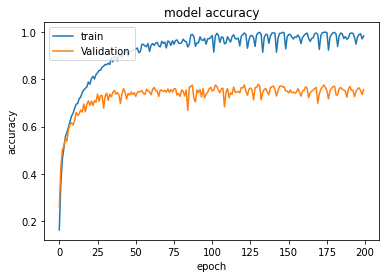

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMDoubleDense/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.763274992583803

In [ ]:
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.7687629783447049

In [ ]:
#converting predicted labels to waypoins.
pred_df=pd.DataFrame(yhat,columns=['Label'])
label_df=pd.DataFrame(label,columns=['X_up_limit','Y_up_limit','Label'])
label_df.head()
pred_df2 = pd.merge(pred_df, label_df, on='Label', how='left')
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,214.213216,169.39878
1,78,214.213216,169.39878
2,78,214.213216,169.39878
3,78,214.213216,169.39878
4,78,214.213216,169.39878


In [ ]:
wp_pred=list()
#Adjust wp to centers
distx=(label[1][0]-label[0][0])/2
disty=(label[10][1]-label[0][1])/2 #for 10X10 grid
pred_df2['X_up_limit']=pred_df2['X_up_limit']-distx
pred_df2['Y_up_limit']=pred_df2['Y_up_limit']-disty
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,78,204.347734,163.499172
1,78,204.347734,163.499172
2,78,204.347734,163.499172
3,78,204.347734,163.499172
4,78,204.347734,163.499172


In [ ]:
#Now we will calculate exact error in predicted and actual location
#We will consider only those waypoints which were present in the original data
#to calculate error and we will reject interpolated values which were introduced by us 
import math
sum_of_error=0
sum_sq_error=0
count=0
test_predicted=pred_df2[['X_up_limit','Y_up_limit']].values
for i in range(len(test_seq_wp)):
  for j in range(len(test_seq_wp[i])):
    if(test_seq_wp[i][j][2]==1):
      sum_of_error+=math.sqrt(((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2))
      sum_sq_error+=((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2)
      count+=1


MAE=sum_of_error/count
RMSE=math.sqrt(sum_sq_error/count)
print('MAE value is:',round(MAE,2))  
print('RMSE value is:',round(RMSE,2))

MAE value is: 19.09
RMSE value is: 29.26
